# Adjusts U.S. dollars for inflation
[A Python library that quickly adjusts U.S. dollars for inflation using the Consumer Price Index (CPI).](https://palewi.re/docs/cpi/)

インフレ率は経済の平均物価水準の上昇度合を反映した値です。経済データの一部には、インフレ率で調整をする必要があるデータもあります。
ここでは消費者物価指数 (CPI)を用いて時系列データに対してインフレ調整をしてみます。

In [1]:
import os
import cpi
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from full_fred.fred import Fred
from datetime import date


cpi.update()  # 必ず実行する

## FREDからデータを取得する
[FRED](https://fred.stlouisfed.org/)から必要なデータを取得します。データの取得方法については別動画で説明していますが、pythonからアクセスするためにはAPIキーの発行が必要です。

In [2]:
# FRED_API_KEY = os.getenv('FRED_API_KEY')
fred = Fred()
print(f"FRED APIキーが環境変数に設定されている：{fred.env_api_key_found()}")


def get_fred_data(name, start="2013-01-01", end=""):
    df = fred.get_series_df(name)[["date", "value"]].copy()
    df["date"] = pd.to_datetime(df["date"])
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df = df.set_index("date")

    if end == "":
        df = df.loc[f"{start}":]
    else:
        df = df.loc[f"{start}":f"{end}"]

    return df

FRED APIキーが環境変数に設定されている：True


## Household Income in the United States
[Median Household Income in the United States (MEHOINUSA646N)](https://fred.stlouisfed.org/series/MEHOINUSA646N)のデータを確認してみます。このデータは、データの単位が

> Units:  Current Dollars, Not Seasonally Adjusted

となっており、このデータはインフレ調整・季節調整がされていません。
この家計データをインフレ率を用いて調整してみます。調整済みのデータの場合は

> Units: XXX Adjusted Dollars

などと表示されます。

In [3]:
data = get_fred_data("MEHOINUSA646N", start="2013-01-01", end="")
data.head()

,value
date,
2013-01-01,53585
2014-01-01,53657
2015-01-01,56516
2016-01-01,59039
2017-01-01,61136


### CPIを用いて値を調整する

In [4]:
data["adjusted"] = [
    cpi.inflate(dollers.value, date.year) for date, dollers in data.iterrows()
]

### 調整前と調整後の比較

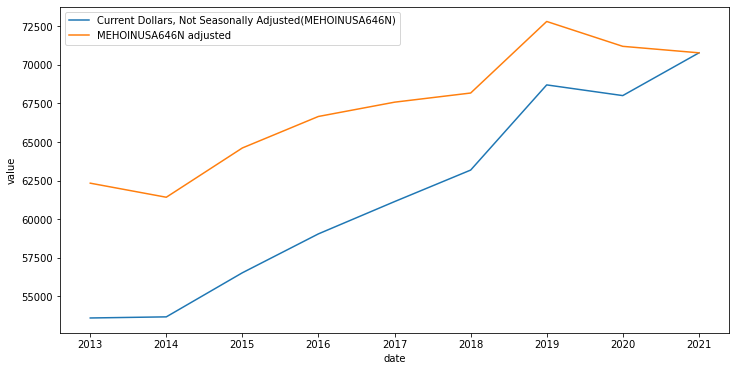

In [5]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=data,
    x="date",
    y="value",
    label="Current Dollars, Not Seasonally Adjusted(MEHOINUSA646N)",
)
sns.lineplot(data=data, x="date", y="adjusted", label="MEHOINUSA646N adjusted")
plt.legend()

## Real Median Household Income in the United States
調整済みのデータは[Real Median Household Income in the United States (MEHOINUSA672N)](https://fred.stlouisfed.org/series/MEHOINUSA672N)にて提供されています。先ほどインフレ調整したデータ（`data`の中にある`adjusted`列の値）とMEHOINUSA672Nの値を比較してみます。調整前の値を消費者物価指数 (CPI)を用いて調整したものは、調整済みの値（MEHOINUSA672N）とほとんど一致するのが期待値です。

In [6]:
data_real = get_fred_data("MEHOINUSA672N", start="2013-01-01", end="")
data_real.head()

,value
date,
2013-01-01,62425
2014-01-01,61468
2015-01-01,64631
2016-01-01,66657
2017-01-01,67571


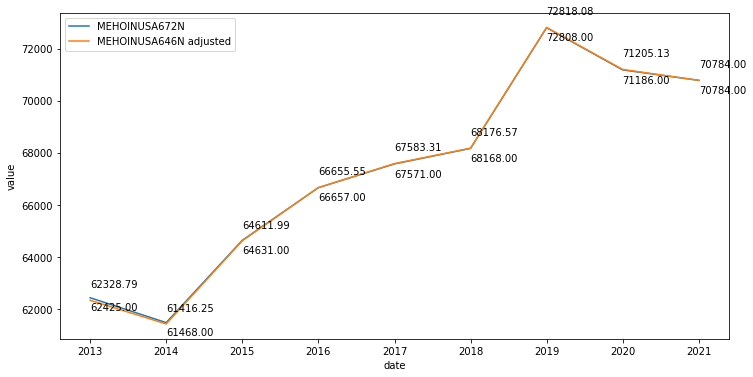

In [7]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_real, x="date", y="value", label="MEHOINUSA672N")
sns.lineplot(data=data, x="date", y="adjusted", label="MEHOINUSA646N adjusted")

# 確認のため、プロットした値をテキストで表示しています
for t, v in data_real.iterrows():
    plt.text(t, v[0] - 500, f"{v[0]:.2f}")

for t, v in data.iterrows():
    plt.text(t, v[1] + 500, f"{v[1]:.2f}")

plt.legend()